In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib 
import numpy as np
from scipy import optimize
from mpl_toolkits.mplot3d import Axes3D
import pyiast # install local version in this folder via python setup.py install
plt.matplotlib.font_manager.fontManager.addfont("one_d_sensing/OpenSans-Regular.ttf")
plt.style.use("one_d_sensing/grandbudapest.mplstyle")
from matplotlib.offsetbox import TextArea, DrawingArea, OffsetImage, AnnotationBbox
import matplotlib.image as mpimg
import os
from sklearn import neighbors
from matplotlib.patches import ConnectionPatch

import warnings
warnings.filterwarnings("ignore")
print("WARNING: you are turning off warnings!")

import cmocean

In /home/cokes/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/cokes/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/cokes/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /home/cokes/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/cokes/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylel

Cory's build to enable cubic interp


# load in adsorption data
CO$_2$ and CH$_4$ adsorption in HKUST-1 and MOF-5 at 25 C

(source in .csv files)


In [2]:
mofs = ["HKUST-1", "IRMOF-1"]
gases = ["co2", "ch4"]
molecular_weight = {"ch4":16.04, "co2":44.01}
df = dict()
for mof in mofs:
    df[mof] = dict()
    for gas in gases:
        df[mof][gas] = pd.read_csv(os.path.join("adsorption_data", gas + "_" + mof + "_25C.csv"), skiprows = 1)
        if gas == "ch4":
            df[mof][gas]["N(mmol/g)"] = df[mof][gas]["N(cm3/g)"] / 22.4
        df[mof][gas]["N(g/g)"] = df[mof][gas]["N(mmol/g)"] * molecular_weight[gas] / 1000 

df["IRMOF-1"]["co2"]

,P(bar),N(mmol/g),N(g/g)
0,0.0,0.0,0.000000
1,1.2,1.1,0.048411
2,2.1,1.8,0.079218
3,3.2,2.8,0.123228
4,4.1,3.7,0.162837
5,5.3,4.9,0.215649
6,6.3,6.1,0.268461
7,7.2,7.1,0.312471
8,8.2,8.4,0.369684
9,9.4,10.1,0.444501


# Construct Adsorption Models
this is for `pyiast`

use interpolator isotherm for CO$_2$ in MOF-5 b/c of the inflection for which we do not have an analytical model.

note the IAST should be done on a mole basis.

In [3]:
gas_to_label = {"co2": "CO$_2$", "ch4": "CH$_4$"} # for latex
p_max_in_plot = {"co2": 50.0, "ch4": 100.0}
mof_to_color = {"IRMOF-1": "C0", "HKUST-1": "C3"}
gas_to_marker = {"co2": "s", "ch4": "o"}

In [4]:
ads_model = dict()
for mof in mofs:
    ads_model[mof] = dict()
    for gas in gases:
        if gas == "co2" and mof == "IRMOF-1":
            wts = np.ones(df[mof][gas].shape[0])
            wts[0] = 100000.0
            ads_model[mof][gas] = pyiast.InterpolatorIsotherm(df[mof][gas],
                                                              pressure_key="P(bar)",
                                                              loading_key="N(mmol/g)",
                                                              interp_kind="UnivariateSpline",
                                                              interp_s=0.1,
                                                              interp_w=wts,
                                                              fill_value=df[mof][gas]["N(mmol/g)"].max()) 
        else:
            ads_model[mof][gas] = pyiast.ModelIsotherm(df[mof][gas],
                                                       pressure_key="P(bar)",
                                                       loading_key="N(mmol/g)",
                                                       model="Langmuir")
      

In [5]:
ads_model["IRMOF-1"]["co2"].loading(0.00)

array(1.18167856e-11)

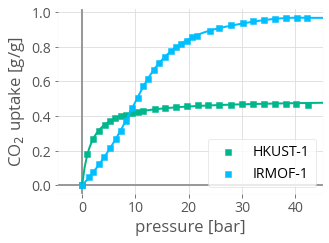

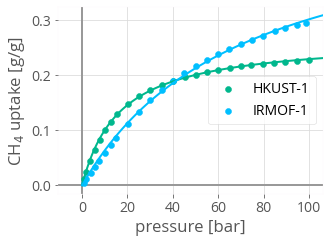

In [6]:
def draw_axes():
    plt.axvline(x=0, color="0.6", zorder=1)
    plt.axhline(y=0, color="0.6", zorder=1)

p_max = {"ch4": 106.0, "co2": 45.1}

viz_fits = True
for gas in gases:
    p = np.linspace(0.0, p_max[gas], 100)
    plt.figure(figsize=[6.4* 0.75, 4.8* 0.75])
    for mof in mofs:
        plt.scatter(df[mof][gas]["P(bar)"], df[mof][gas]["N(g/g)"], color=mof_to_color[mof], 
                    zorder=100, marker=gas_to_marker[gas], label=mof)
        if viz_fits:
            plt.plot(p, ads_model[mof][gas].loading(p) * molecular_weight[gas] / 1000, color=mof_to_color[mof], zorder=100)
    draw_axes()
    plt.legend()
    plt.xlabel("pressure [bar]")
    plt.ylabel(gas_to_label[gas] + " uptake [g/g]")
    plt.tight_layout()
    plt.xlim([-0.1 * p_max[gas], p_max[gas]])
#     plt.ylim([0, 0.2])
    if viz_fits:
        plt.savefig(gas + "_adsorption_data_fits.pdf", format="pdf") # in  mapping nb
    else:
        plt.savefig(gas + "_adsorption_data.pdf", format="pdf") # in  mapping nb

In [7]:
ads_model["HKUST-1"]["co2"].params # e.g. get params

{'M': 11.258065222216736, 'K': 0.5719565569097571}

In [8]:
ads_model["IRMOF-1"]["ch4"].params["M"] * 16.04 / 1000 # e.g. get params

0.51723917017413

In [9]:
ads_model["HKUST-1"]["co2"].loading(0.2) # e.g. compute loading at 0.2 bar

1.155630729744193

# Adsorption model $\mathbf{m}=f(\mathbf{p})$

In [10]:
"""
    m_i = f_i(p, mof)

return adsorbed mass in the MOF as a function of pressure. it will be a vector, one component for each gas.

both m_i and p are arrays here.

note: we apply iast to the mmol/g adsorption values, then convert to g/g

m[i]: total mass adsorbed in MOF i
p[i]: partial pressure of gas i
"""
def f_i(p, mof):
    m_i = np.array([0.0, 0.0]) # one for each component
    # if gas is pure gas 1
    if p[0] == 0.0:
        m_i[1] = ads_model[mof][gases[1]].loading(p[1]) * molecular_weight[gases[1]] / 1000
        return m_i
    #  if gas is pure gas 0
    if p[1] == 0.0:
        m_i[0] = ads_model[mof][gases[0]].loading(p[0]) * molecular_weight[gases[0]] / 1000
        return m_i
    # if reached this far, need IAST
    # first, a reasonable guess for adsorbed_mole_fraction_guess
    #  based on pure-component loadings
    # component loadings in mof i.
    #  note that these are in mmol. so we need to use molecular weight to convert to g.
    m_i = pyiast.iast(p, [ads_model[mof][gas] for gas in gases],
                    verboseflag=False,
                    warningoff=True)
    for g, gas in enumerate(gases):
        # convert to g/g
        m_i[g] = m_i[g] * molecular_weight[gas] / 1000
    return m_i

"""
    m = f(p)

return adsorbed mass in the MOFs as a function of pressure.

both m and p are arrays here.

note: we apply iast to the mmol/g adsorption values, then convert to g/g

m[i]: total mass adsorbed in MOF i
p[i]: partial pressure of gas i
"""
def f(p):
    if np.any(p < 0.0):
        # tell optim algo this is the wrong direction!
        return np.array([-1.0, -1.0]) * np.linalg.norm(p)
    m = np.zeros(2)
    for i, mof in enumerate(mofs):
        m[i] = np.sum(f_i(p, mof))
    return m # g/g
# turn warningoff=False to see if there are warnings.

In [11]:
p = np.array([5.0, 4.0])
m = f(p)
m

array([0.35548845, 0.23333815])

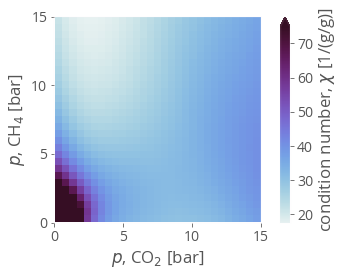

In [12]:
# import numdifftools as nd
import numdifftools.nd_scipy as nd
p_max = 15.0
J_f = nd.Jacobian(f, method="forward") # a function!

def condition_no(p):
    j = J_f(p) # Jacobian of f(p) at p
    return 1 / np.min(np.linalg.svd(j)[1]) / np.linalg.norm(p) # operator norm of inverse of j = J_g(m)

ps = np.linspace(0.1, p_max, 30)
z = [[condition_no(np.array([p_x, p_y])) for p_x in ps] for p_y in ps]

fig, ax = plt.subplots()
plt.pcolor(ps, ps, z, cmap=cmocean.cm.dense, vmax=75.0)
plt.xlabel("$p$, " + gas_to_label[gases[0]] + " [bar]")
plt.ylabel("$p$, " + gas_to_label[gases[1]] + " [bar]")
plt.colorbar(label="condition number, $\chi$ [1/(g/g)]", extend="max")
plt.xlim(xmin=-0.01)
plt.ylim(ymin=-0.01)
plt.xticks([0, 5, 10, 15])
plt.yticks([0, 5, 10, 15])
ax.set_aspect('equal', 'box')
plt.tight_layout()
plt.savefig("conditioning.pdf", format="pdf")

# Inverse of adsorption model $\mathbf{p}=g(\mathbf{m})$

## k-NN algo for good guess
forward function `f` is robust.

inverse function `g` is not... i.e. will not converge if the starting guess is not very close to the true solution.
so let's use nearest neighbors to get a good guess for the inverse function.

In [13]:
ps = np.concatenate((np.linspace(0, 5.0, 50), np.linspace(3.0, 30.0, 100)[2:], np.linspace(50.0, 1000.0, 25)))
knn = neighbors.KNeighborsRegressor(1)
P = []
M = []
for i in range(len(ps)):
    for j in range(len(ps)):
        p = np.array([ps[i], ps[j]])
        P.append(p)
        M.append(f(p))
knn_model = knn.fit(M, P) # the inverse problem

def g_knn(m):
    return knn_model.predict([m])[0]

In [14]:
def distance_to_nearest_neighbor(m):
    return knn_model.kneighbors([m])[0][0][0]

In [15]:
g_knn(m)

array([5.        , 3.97959184])

In [16]:
"""
    p = g(m)

inverse of f(p). i.e. given m, return p that produces it.
if not a successful root finding, return Nans
"""
def g(m):
    if np.linalg.norm(m) < 1e-6:
        return np.array([0.0, 0.0])
    def f_want_0(p):
        return f(p) - m
    p_guess = g_knn(m)
    method = "hybr" # default
    if p_guess[0] < 4.0 or p_guess[1] < 4.0:
        method = "lm" # works better for small p, but slower
    sol = optimize.root(f_want_0, p_guess, method=method)
    p = sol.x
    if not sol.success:
#         print(sol.message)
        return np.array([np.nan, np.nan])
    # crazy that we need this, but sometimes sol.success is true and it doesn't satisfy this.
    if not np.linalg.norm(f_want_0(p)) < 1e-6:
        return np.array([np.nan, np.nan])
    return p

In [17]:
m

array([0.35548845, 0.23333815])

In [18]:
g(m)

array([5., 4.])

# Function to draw boundary on response space

In [19]:
# Function to draw boundary around response space figure
boundary_kwargs = {"color": "k", "lw": 4, "clip_on": False, "zorder": 100}
def draw_mspace_boundaries(p_max, plt_num, nb_pts=100):
    x = np.linspace(0, p_max, nb_pts)
    m_0 = np.zeros(len(x))
    m_1 = np.zeros(len(x))
    for i in range(len(x)):
        # make p_0 = 0
        p_1 = x[i]
        m_0[i] = ads_model[mofs[0]][gases[1]].loading(p_1) * molecular_weight[gases[1]] / 1000
        m_1[i] = ads_model[mofs[1]][gases[1]].loading(p_1) * molecular_weight[gases[1]] / 1000
    ax[plt_num].plot(m_0, m_1, **boundary_kwargs)
    for i in range(len(x)):
        # make p_1 = 0
        p_0 = x[i]
        m_0[i] = ads_model[mofs[0]][gases[0]].loading(p_0) * molecular_weight[gases[0]] / 1000
        m_1[i] = ads_model[mofs[1]][gases[0]].loading(p_0) * molecular_weight[gases[0]] / 1000
    ax[plt_num].plot(m_0, m_1, **boundary_kwargs)
    for i in range(len(x)):        
        # make pa = max
        p = np.array([p_max, x[i]])
        m_0[i], m_1[i] = f(p) 
    ax[plt_num].plot(m_0, m_1, **boundary_kwargs)
    for i in range(len(x)):        
        # make pb = max
        p = np.array([x[i], p_max])
        m_0[i], m_1[i] = f(p) 
    ax[plt_num].plot(m_0, m_1, **boundary_kwargs)
    
def draw_box(L, plt_num):
    ax[plt_num].hlines(0.0, 0.0, L, **boundary_kwargs)
    ax[plt_num].hlines(L  , 0.0, L, **boundary_kwargs)
    ax[plt_num].vlines(0.0, 0.0, L, **boundary_kwargs)
    ax[plt_num].vlines(L  , 0.0, L, **boundary_kwargs)

# simple way

In [20]:
bkg_color = (0.96, 0.96, 0.96, 1.0)
figsize = (13, 5)
cmaps = [plt.cm.turbo, plt.cm.turbo]
kwargs = {'lw': 2, 'clip_on': False}
p_max = 15.0
nb_lines = 6

m_max = np.array([0.0, 0.0]) # fill in later

In [21]:
def prep_plot(gas_axis, response_axis):
    for k in range(2):
        ax[k].grid(False)
        ax[k].set_facecolor(bkg_color)

    ax[gas_axis].set_title("gas composition space, $\mathcal{P}$")
    ax[gas_axis].set_xlabel("$p$, " + gas_to_label[gases[0]] + " [bar]")
    ax[gas_axis].set_ylabel("$p$, " + gas_to_label[gases[1]] + " [bar]")

    ax[response_axis].set_title("sensor response space, $\mathcal{M}$")
    ax[response_axis].set_xlabel("$m$, " + mofs[0] + " [g/g]")
    ax[response_axis].set_ylabel("$m$, " + mofs[1] + " [g/g]")
    
    ax[gas_axis].set_xlim([0, p_max])
    ax[gas_axis].set_ylim([0, p_max])
    ax[response_axis].set_xlim(xmin=0.0)
    ax[response_axis].set_ylim(ymin=0.0)
    
    for k in range(2): 
        ax[k].set_aspect('equal', 'box')

Number of calls to function has reached maxfev = 400.
Number of calls to function has reached maxfev = 400.


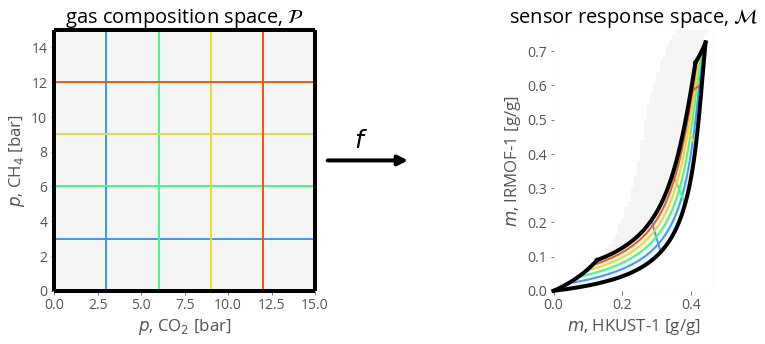

In [22]:
fig, ax = plt.subplots(1, 2, figsize=figsize)

ps = np.linspace(0, p_max, nb_lines)

for p_i in ps:
    ###
    #   x = constant (vertical) grid lines
    ###
    p_0 = p_i # p_0 is constant here.
    color = cmaps[0](p_0 / p_max)
    
    ax[0].vlines(p_0, 0, p_max, color=color, **kwargs)

    # plot the image of the line in sensor response space
    #     loop through points on the line
    nb_pts = 50
    p_fine = np.linspace(0, p_max, nb_pts)
    m_0 = np.zeros(nb_pts)
    m_1 = np.zeros(nb_pts)
    for j, p_1 in enumerate(p_fine):
        p = np.array([p_0, p_1])
        m_0[j], m_1[j] = f(p)
    ax[1].plot(m_0, m_1, color=color, **kwargs)
    
    m_max[0] = np.max(m_0)
    m_max[1] = np.max(m_1)
    ###
    #   y = constant (horizontal) grid lines
    ###
    p_1 = p_i # p_0 is constant here.
    color = cmaps[1](p_1 / p_max)

    ax[0].hlines(p_1, 0, p_max, color=color, **kwargs)

    # plot the image of the line in sensor response space
    # loop through points on the line
    for j, p_0 in enumerate(p_fine):
        p = np.array([p_0, p_1])
        m_0[j], m_1[j] = f(p)
    ax[1].plot(m_0, m_1, color=color, **kwargs)
    
    m_max[0] = np.max(np.concatenate([[m_max[0]], m_0]))
    m_max[1] = np.max(np.concatenate([[m_max[1]], m_1]))
    
draw_mspace_boundaries(p_max, 1)
draw_box(p_max, 0)
prep_plot(0, 1)

# draw image
nb_pts = 50
dms = m_max * 0.05
f_range = [[bkg_color for i in range(nb_pts)] for j in range(nb_pts)]
for i, m_0 in enumerate(np.linspace(0, m_max[0] + dms[0], nb_pts)):
    for j, m_1 in enumerate(np.linspace(0, m_max[1] + dms[1], nb_pts)):
        m = np.array([m_0, m_1])
        try:
            p = g(m)
            if np.any(np.isnan(p)) or np.any(p < 0.0):
                f_range[j][i] = (1.0, 1.0, 1.0, 1.0)
        except:
            f_range[j][i] = (1.0, 1.0, 1.0, 1.0)
        
ax[1].imshow(f_range, extent=(0, m_max[0] + dms[0], 0, m_max[1]+ dms[1]),  origin='lower')

# draw!
con = ConnectionPatch(xyA=(1.01, 0.5), xyB=(-0.85, 0.5), 
                      coordsA="axes fraction", coordsB="axes fraction",
                      axesA=ax[0], axesB=ax[1], arrowstyle="-|>", zorder=10000, 
                      clip_on=False, fc="w", mutation_scale=20, shrinkA=10, shrinkB=10)
con.set_color([0, 0, 0])
ax[0].add_artist(con)
con.set_linewidth(4)
ax[0].text(1.175, 0.575, "$f$", horizontalalignment='center',
    verticalalignment='center', transform=ax[0].transAxes, fontsize=25)

plt.tight_layout()
plt.savefig("p_to_m_2d.pdf", format="pdf")

In [23]:
###
#   vertical lines.
#   m_0 known. what is [m_1_start, m_1_end]?
m_top_left = f(np.array([0.0, p_max]))
m_top_right = f(np.array([p_max, p_max])) # def related to comp space not resp space

# bottom of vert line: p_1 = 0. wut is p_0?
def get_m1_start(m_0):
    # wut pressure of gas 0 gives this m_0? look at pure-component of gas 0 in mof 0
    def f_want_0(p_0):
        return ads_model[mofs[0]][gases[0]].loading(p_0) * molecular_weight[gases[0]] / 1000 - m_0
    p_0 = optimize.root_scalar(f_want_0, bracket=[0, 1.1 * p_max]).root # x[0]
    # retrun m_1 at this p_0
    return ads_model[mofs[1]][gases[0]].loading(p_0) * molecular_weight[gases[0]] / 1000

# top of vert line: p_1 = p_max. wut is p_0?
def get_m1_end(m_0):
    if m_0 < m_top_left[0]: # p = [0.0, p_1] for some p_1
        # wut pressure of gas 0 gives this m_0? look at pure-component of gas 0 in mof 0
        def f_want_0(p_1):
            p = np.array([0.0, p_1])
            return f(p)[0] - m_0
        p_1 = optimize.root_scalar(f_want_0, x0=p_max * m_0 / 0.5, bracket=[0.0, p_max]).root
        p = np.array([0.0, p_1])
        return f(p)[1]
    elif m_0 > m_top_right[0]: # p_0 = p_max
        def f_want_0(p_1):
            p = np.array([p_max, p_1])
            return f(p)[0] - m_0
        p_1 = optimize.root_scalar(f_want_0, x0=p_max * m_0 / 0.5, bracket=[0.0, p_max]).root
        p = np.array([p_max, p_1])
        return f(p)[1]
    else:  # p = [p_0, p_max]
        # wut pressure of gas 0 gives this m_0? look at pure-component of gas 0 in mof 0
        def f_want_0(p_0):
            p = np.array([p_0, p_max])
            return f(p)[0] - m_0
        p_0 = optimize.root_scalar(f_want_0, x0=p_max * m_0 / 0.5, bracket=[0.0, p_max]).root
        p = np.array([p_0, p_max])
        return f(p)[1]
###
#   horizontal lines.
#   m_1 known. what is [m_0_start, m_0_end]?

# left of horiz line: p_0 = 0. wut is p_1?
def get_m0_start(m_1):
    if m_1 < m_top_left[1]:
        # wut pressure of gas 1 gives this m_1? look at pure-component of gas 1 in mof 1
        def f_want_0(p_1):
            return ads_model[mofs[1]][gases[1]].loading(p_1) * molecular_weight[gases[1]] / 1000 - m_0
        p_1 = optimize.root_scalar(f_want_0, x0=p_max / 2, bracket=[0.0, p_max]).root
        # retrun m_0 at this p_1
        return ads_model[mofs[0]][gases[1]].loading(p_1) * molecular_weight[gases[1]] / 1000
    elif m_1 > m_top_right[1]:
        # p0 = pmax is all we kno
        def f_want_0(p_1):
            p = np.array([p_max, p_1])
            return f(p)[1] - m_1
        p_1 = optimize.root_scalar(f_want_0, x0=p_max / 2, bracket=[0.0, p_max]).root
        p = np.array([p_max, p_1])
        return f(p)[0]
    else:
        # p_1 = p_max, gotta find p_0
        def f_want_0(p_0):
            p = np.array([p_0, p_max])
            return f(p)[1] - m_1
        p_0 = optimize.root_scalar(f_want_0, x0=p_max / 2, bracket=[0.0, p_max]).root
        p = np.array([p_0, p_max])
        return f(p)[0]

# right of horiz line for fixed m1
def get_m0_end(m_1):
    # p_1 = 0.0. wut is p_0?
    def f_want_0(p_0):
        p = np.array([p_0, 0.0])
        return f(p)[1] - m_1
    p_0 = optimize.root(f_want_0, p_max).x[0]
    p = np.array([p_0, 0.0])
    return f(p)[0]

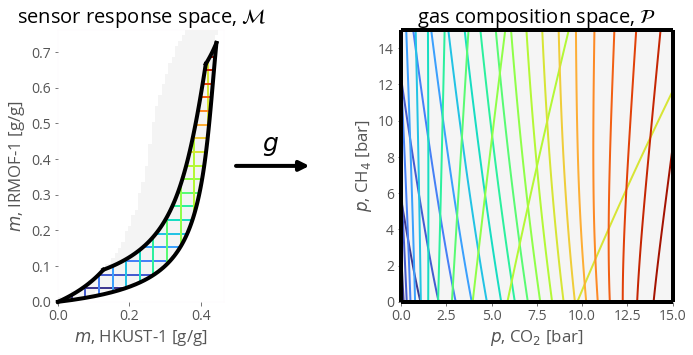

In [24]:
draw_circles = False

fig, ax = plt.subplots(1, 2, figsize=figsize)

if draw_circles:
    thetas = np.linspace(0, 2*np.pi, 50)
    dm = 0.0115
    def draw_circle(p_bar, color):
        m_bar = f(p_bar)
        
        # draw pt as X
        ax[0].scatter([m_bar[0]], [m_bar[1]], color=color, marker="X")
        ax[1].scatter([p_bar[0]], [p_bar[1]], color=color, marker="X")
        
        # draw circles
        ms = [m_bar + dm * np.array([np.cos(theta), np.sin(theta)]) for theta in thetas]
        ps = [g(m) for m in ms]
        if np.any(np.isnan(np.array(ps))) or np.any(np.array(ps) > p_max):
            print("error zone out of composition space for p_bar = ", p_bar)
        for i in range(len(thetas)-1):
            ax[0].plot([ms[i][0], ms[i+1][0]], [ms[i][1], ms[i+1][1]], color=color, zorder=12000)
            ax[1].plot([ps[i][0], ps[i+1][0]], [ps[i][1], ps[i+1][1]], color=color, zorder=12000)
        ax[0].fill([ms[i][0] for i in range(len(thetas)-1)], [ms[i][1] for i in range(len(thetas)-1)], 
                   color=color, zorder=12000, alpha=0.25)
        ax[1].fill([ps[i][0] for i in range(len(thetas)-1)], [ps[i][1] for i in range(len(thetas)-1)], 
                   color=color, zorder=12000, alpha=0.25)

    # determine location of evenly spaced circles in vert direction
    nb_circles = 3 # well, in each direction
    ps_circle = [[0.5, 3.0], [5.0, 5.0], [10.0, 7.5], [2.0, 10.0], [7.5, 10.0], [13.5, 6.0]]
    c = 0
    for p_bar in ps_circle:
        color = 'C{0}'.format(c)
        draw_circle(np.array(p_bar), color)
        c += 1

if not draw_circles:  
    nb_lines = 20
    ms = np.linspace(0, np.max(m_max), nb_lines)
    for m_i in ms:
        ###
        #   x = constant (vertical) grid lines
        ###
        m_0 = m_i # m_0 is constant here.
        if m_0 < m_max[0]:
            color = cmaps[0](m_0 / np.max(m_max))

            m1_min = get_m1_start(m_0)
            m1_max = get_m1_end(m_0)

            ax[0].vlines(m_0, m1_min, m1_max, color=color, **kwargs)

            # plot the image of the line in gas composition space
            #     loop through points on the line
            nb_pts = 50
            m1_fine = np.linspace(m1_min, m1_max, nb_pts)
            p_0 = np.zeros(nb_pts)
            p_1 = np.zeros(nb_pts)
            for j, m_1 in enumerate(m1_fine):
                m = np.array([m_0, m_1])
                p_0[j], p_1[j] = g(m)
            ax[1].plot(p_0, p_1, color=color, **kwargs)

        ###
        #   y = constant (horizontal) grid lines
        ###
        m_1 = m_i # m_0 is constant here.
        if m_1 < m_max[1]:
            color = cmaps[1](m_1 / np.max(m_max))

            m0_min = get_m0_start(m_1)
            m0_max = get_m0_end(m_1)

            ax[0].hlines(m_1, m0_min, m0_max, color=color, **kwargs)

            # plot the image of the line in gas composition space
            #     loop through points on the line
            nb_pts = 50
            m0_fine = np.linspace(m0_min, m0_max, nb_pts)
            p_0 = np.zeros(nb_pts)
            p_1 = np.zeros(nb_pts)
            for j, m_0 in enumerate(m0_fine):
                m = np.array([m_0, m_1])
                p_0[j], p_1[j] = g(m)
            ax[1].plot(p_0, p_1, color=color, **kwargs)
        
draw_mspace_boundaries(p_max, 0)
draw_box(p_max, 1)
prep_plot(1, 0)
ax[0].imshow(f_range, extent=(0, m_max[0] + dms[0], 0, m_max[1]+ dms[1]),  origin='lower') # from above

# draw!
con = ConnectionPatch(xyA=(1.01, 0.5), xyB=(-0.3, 0.5), 
                      coordsA="axes fraction", coordsB="axes fraction",
                      axesA=ax[0], axesB=ax[1], arrowstyle="-|>", zorder=10000, 
                      clip_on=False, fc="w", mutation_scale=20, shrinkA=10, shrinkB=10)
con.set_color([0, 0, 0])
ax[0].add_artist(con)
con.set_linewidth(4)
ax[0].text(1.275, 0.575, "$g$", horizontalalignment='center',
    verticalalignment='center', transform=ax[0].transAxes, fontsize=25)

if draw_circles:
    plt.savefig("m_to_p_2d_circles.pdf", format="pdf")
else:
    plt.savefig("m_to_p_2d.pdf", format="pdf")

# Conditionining

# component loadings

max m_i co2 in HKUST-1 0.44374499164255304
max m_i ch4 in HKUST-1 0.12676039869751907
max m_i co2 in IRMOF-1 0.7254655550461953
max m_i ch4 in IRMOF-1 0.0897280270595291


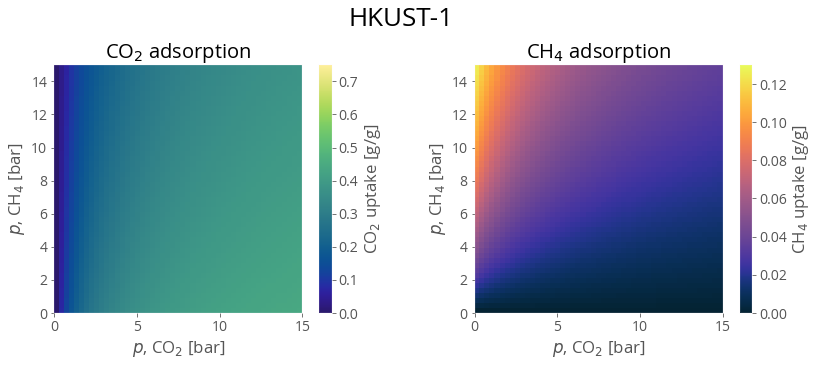

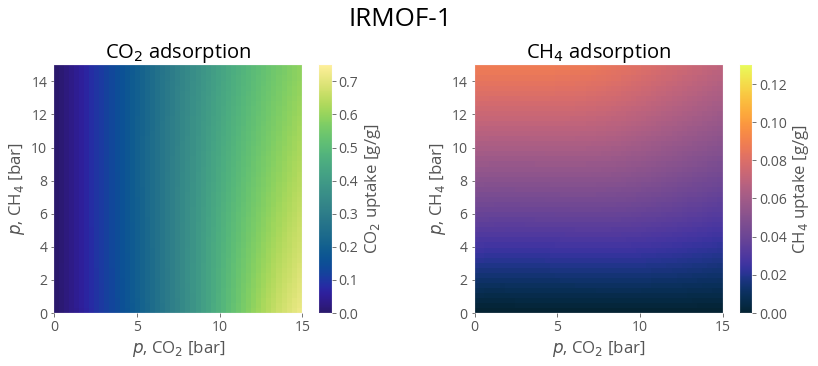

In [25]:
ps = np.linspace(0, p_max)
cmaps = [cmocean.cm.haline, cmocean.cm.thermal]
vmax = [0.75, 0.13]

for mof in mofs:
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))
    plt.suptitle(mof, fontsize=26)
    
    for gi, gas in enumerate(gases):
        ax[gi].set_title(gas_to_label[gas] + " adsorption")
        ax[gi].set_xlabel("$p$, " + gas_to_label[gases[0]] + " [bar]")
        ax[gi].set_ylabel("$p$, " + gas_to_label[gases[1]] + " [bar]")
    
    m = [[[0.0 for p_x in ps] for p_y in ps] for i in range(2)]
    
    for i, p_0 in enumerate(ps):
        for j, p_1 in enumerate(ps):
            p = np.array([p_0, p_1])
            m_i = f_i(p, mof)
            
            for g, gas in enumerate(gases):
                m[g][j][i] = m_i[g]
    
    for g, gas in enumerate(gases):
        print("max m_i " + gas + " in " + mof, np.max(m[g]))
        muh_plot = ax[g].pcolor(ps, ps, m[g], cmap=cmaps[g], vmax=vmax[g])
        fig.colorbar(muh_plot, ax=ax[g], label=gas_to_label[gas] + " uptake [g/g]")
    for k in range(2): 
        ax[k].set_aspect('equal', 'box')
        
    plt.tight_layout()
    plt.savefig(mof + "components_adsorption.pdf", format="pdf")